In [104]:
import cv2         
import numpy as np   
import matplotlib.pyplot as plt

In [105]:
def turnGrayscale(image_path):    
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray , cmap='gray')
    plt.title('Turn gray Image')
    plt.show()
    return img_gray

In [106]:
def adaptiveThresholding(image, block_size=15, C=2, method='gaussian'):
   
    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Select the adaptive method
    if method.lower() == 'gaussian':
        adaptive_method = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    else:
        adaptive_method = cv2.ADAPTIVE_THRESH_MEAN_C

    # Apply adaptive thresholding
    thresholded_image = cv2.adaptiveThreshold(
        image,
        255,  # Max intensity value
        adaptive_method,  # Adaptive method
        cv2.THRESH_BINARY,  # Binary thresholding
        block_size,  # Size of the local region
        C  # Constant to fine-tune thresholding
    )

    # Display the result
    plt.imshow(thresholded_image, cmap='gray')
    plt.title(f'Adaptive Thresholding ({method.capitalize()})')
    plt.axis('off')
    plt.show()

    return thresholded_image


In [107]:
def medianFilter(image):
    img_blur = cv2.blur(image, (1, 30))
    img_filtered = cv2.medianBlur(img_blur, 5)

    if len(img_filtered.shape) == 3:
        img_filtered = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2GRAY)

    img_filtered = np.uint8(np.clip(img_filtered, 0, 255))

    _, img_thresh = cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.imshow(img_thresh, cmap='gray')
    plt.title('Median Image')
    plt.show()

    return img_thresh

In [108]:
def histogramStretching(image):
    min = np.min(image)
    max = np.max(image)
    image = np.uint8((image - min) / (max - min) * 255)
    return image

In [109]:
def rotateBarcode(image):

    edges = cv2.Canny(image, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

        angle = rect[-1]
        if angle < -45:
            angle -= 90

        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        img_rotated = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

        box = np.int32(cv2.transform(np.array([box]), rotation_matrix)[0])
        x, y, h, w = cv2.boundingRect(box)

        if h > w:
            img_rotated = cv2.rotate(img_rotated, cv2.ROTATE_90_CLOCKWISE)
    
    plt.imshow(img_rotated , cmap='gray')
    plt.title('Rotated Image')
    plt.show()

    return img_rotated

In [110]:
def closeOpen(image):

    kernel_height = image.shape[0] // 5  
    kernel_width = 1 
    kernel = np.ones((kernel_height, kernel_width), np.uint8)

    img_closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=1)

    img_opened = cv2.morphologyEx(img_closed, cv2.MORPH_OPEN, kernel, iterations=1)

    plt.imshow(img_opened, cmap='gray')
    plt.title('Opened Image')
    plt.show()

    return img_opened

In [111]:
def closeOpenFull(image):

    kernel_height = image.shape[0]   
    kernel_width = 1
    kernel = np.ones((kernel_height, kernel_width), np.uint8)

    img_closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=1)

    img_opened = cv2.morphologyEx(img_closed, cv2.MORPH_OPEN, kernel, iterations=1)

    plt.imshow(img_opened, cmap='gray')
    plt.title('Full opened Image')
    plt.show()

    return img_opened

In [112]:
def extractBarcode(image):
    img_thresh_inv = cv2.bitwise_not(image)

    x, y, w, h = cv2.boundingRect(img_thresh_inv)

    barcode = image[y:y+h-h//4, x:x+w]
    plt.imshow(barcode, cmap='gray')
    plt.title('extract Image')
    plt.show()
    return barcode


In [113]:
def detectSineWaveNoise(image):
    # Ensure the image is not empty
    if image is None or image.size == 0:
        raise ValueError("Input image is empty or invalid.")
    
    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Perform FFT (Fast Fourier Transform)
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift zero frequency component to the center
    
    # Calculate magnitude spectrum
    magnitude_spectrum = np.abs(fshift)
    
    # Display the magnitude spectrum for debugging
    plt.imshow(np.log(magnitude_spectrum + 1), cmap='gray')
    plt.title('Magnitude Spectrum')
    plt.show()
    
    # Calculate the average frequency component
    avg_freq = np.mean(magnitude_spectrum)
    
    # Focus on higher-frequency components to detect noise
    # We'll ignore low-frequency components to avoid the barcode's natural structure
    low_freq_threshold = avg_freq * 1.5  # Exclude low-frequency components
    magnitude_spectrum[magnitude_spectrum < low_freq_threshold] = 0  # Zero out low-frequency components
    
    # Automatically determine a threshold for peak detection based on the remaining spectrum
    peak_threshold = np.max(magnitude_spectrum) * 0.1  # Default 10% of maximum frequency as threshold
    
    # Detect peaks in the high-frequency components
    peaks = np.where(magnitude_spectrum > peak_threshold)
    
    # Check if there are enough peaks to calculate distances
    if len(peaks[0]) < 2:
        print( "No sine wave noise.")
        return False
    
    # Check the spacing between peaks to detect regular sine wave noise
    peak_distances = []
    for i in range(1, len(peaks[0])):
        distance = np.linalg.norm(np.array([peaks[0][i], peaks[1][i]]) - np.array([peaks[0][i-1], peaks[1][i-1]]))
        peak_distances.append(distance)
    
    # Check if the distances between peaks are consistent (indicating periodicity)
    mean_distance = np.mean(peak_distances)
    regularity = np.std(peak_distances) < mean_distance * 0.2  # Tolerance for regularity
    
    if regularity:
        print("Sine wave noise detected!")
        return True
    else:
        print(" No sine wave noise.")
        return False

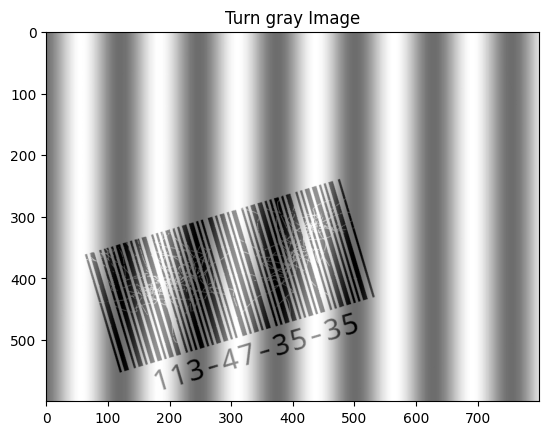

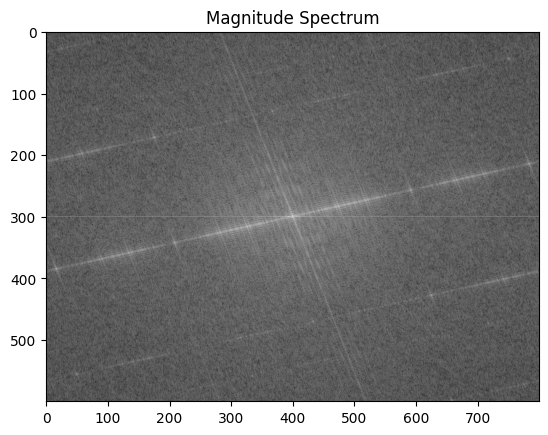

Sine wave noise detected!


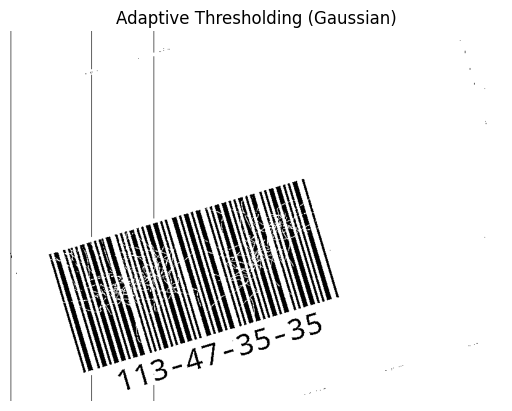

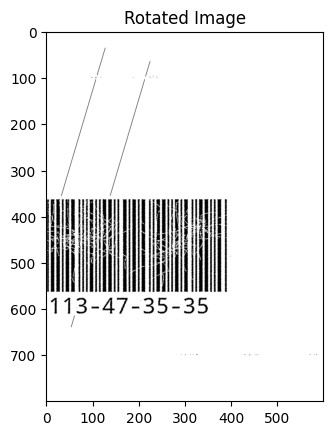

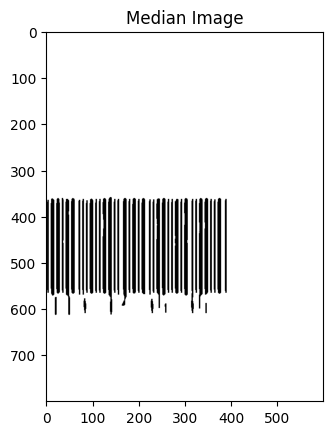

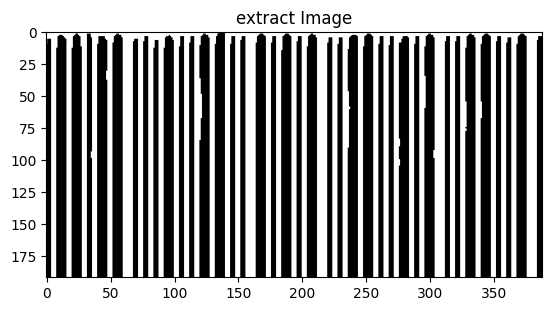

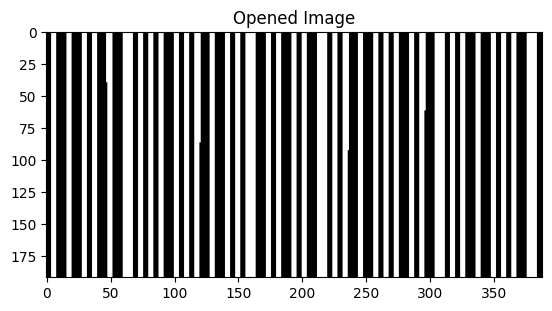

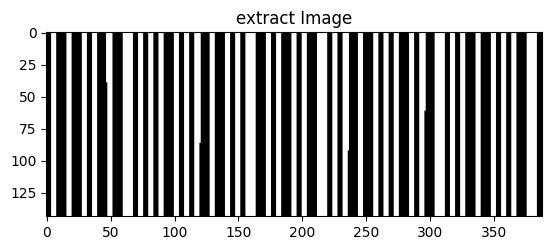

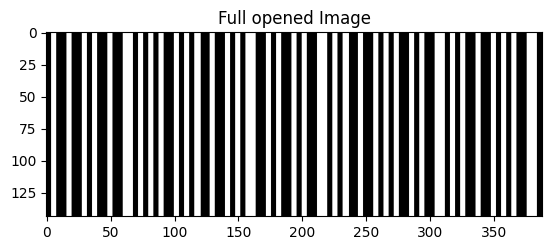

In [115]:
#el rotate me4 4a8ala sa7

#image = turnGrayscale('Test Cases/01 - lol easy.jpg')
#image = turnGrayscale('Test Cases/02 - still easy.jpg')
#image = turnGrayscale('Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg')      
#image = turnGrayscale('Test Cases/04 - fen el nadara.jpg')                            # bayza 3and el rotaion 
#image = turnGrayscale('Test Cases/05 - meen taffa el nour!!!.jpg')                      
#image = turnGrayscale('Test Cases/07 - mal7 w felfel.jpg')                            # bayza 3and el rotaion 
#image = turnGrayscale('Test Cases/08 - compresso espresso.jpg')                         
#image = turnGrayscale('Test Cases/09 - e3del el soora ya3ammm.jpg')                   # bayza 3and el rotaion 
#image = turnGrayscale('Test Cases/10 - wen el kontraastttt.jpg')                       
image = turnGrayscale('Test Cases/11 - bayza 5ales di bsara7a.jpg')                    # bayza 3and el rotaion
#image = turnGrayscale('Test Cases/Screenshot 2024-12-03 220156.png')                  # bayza 3and el rotaion
 
   
sine_wave_noise_detected = detectSineWaveNoise(image)

       
if sine_wave_noise_detected:
    image = adaptiveThresholding(image)

image = histogramStretching(image)
image = rotateBarcode(image)
image = medianFilter(image)

image = extractBarcode(image)

image = closeOpen(image)

image = extractBarcode(image)
image =closeOpenFull(image)
